#### Packages + Datas

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import load_boston
data = load_boston()  #1

import statsmodels.formula.api as smf
url = "http://data.princeton.edu/wws509/datasets/salary.dat"  #2

import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris  #3 / 4

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt                

#####  1 : STEP REGRESSION AIC CRITERIA

In [ ]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target    

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)
print('resulting features:')
print(result)

#### 2-FORWARD FEATURES SELECTION

In [8]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [11]:
data = pd.read_csv(url, sep='\\s+')
model = forward_selected(data, 'sl')
print(data.head(10))
print (model.model.formula)
print (model.rsquared_adj)

       sx    rk  yr         dg  yd     sl
0    male  full  25  doctorate  35  36350
1    male  full  13  doctorate  22  35350
2    male  full  10  doctorate  23  28200
3  female  full   7  doctorate  27  26775
4    male  full  19    masters  30  33696
5    male  full  16  doctorate  21  28516
6  female  full   0    masters  32  24900
7    male  full  16  doctorate  18  31909
8    male  full  13    masters  30  31850
9    male  full  13    masters  31  32850
sl ~ rk + yr + 1
0.835190760537986


#### 3 - SEQUENTIAL FORWARD SELECTION

In [23]:
GREEN = "\033[0;32m"
BLUE  = "\033[1;34m"
iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(knn, 
           k_features=3, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)
sys.stdout.write(BLUE)
sfs1 = sfs1.fit(X, y)
print(sfs1.subsets_)

{1: {'feature_idx': (3,), 'cv_scores': array([0.96]), 'avg_score': 0.96, 'feature_names': ('3',)}, 2: {'feature_idx': (2, 3), 'cv_scores': array([0.97333333]), 'avg_score': 0.9733333333333334, 'feature_names': ('2', '3')}, 3: {'feature_idx': (1, 2, 3), 'cv_scores': array([0.97333333]), 'avg_score': 0.9733333333333334, 'feature_names': ('1', '2', '3')}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-09-03 22:02:13] Features: 1/3 -- score: 0.96[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-09-03 22:02:13] Features: 2/3 -- score: 0.9733333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-09-03 22:02:13] Features: 3/3 -- score: 0.9733333333333334

#### 4 : SFS, SBS, SFFS, and SBFS

In [34]:
# Sequential Forward Selection
sfs = SFS(knn, k_features=3, forward=True, floating=False, scoring='accuracy',cv=5,n_jobs=-1)
sfs = sfs.fit(X, y)
sys.stdout.write(BLUE)
print('\nSequential Forward Selection (k=3):',sfs.k_feature_idx_)
print('CV Score:',sfs.k_score_)

# Sequential Backward Selection
sbs = SFS(knn, k_features=3, forward=False, floating=False, scoring='accuracy',cv=5, n_jobs=-1)
sbs = sbs.fit(X, y)
print('\nSequential Backward Selection (k=3):',sfs.k_feature_idx_)
print('CV Score:',sbs.k_score_)

# Sequential Forward Floating Selection
sffs = SFS(knn, k_features=3, forward=True, floating=True, scoring='accuracy',cv=5, n_jobs=-1)
sffs = sffs.fit(X, y)
print('\nSequential Forward Floating Selection (k=3):',sfs.k_feature_idx_)
print('CV Score:',sffs.k_score_)

# Sequential Backward Floating Selection
sbfs = SFS(knn, k_features=3, forward=False, floating=True, scoring='accuracy',cv=5, n_jobs=-1)
sbfs = sbfs.fit(X, y)
print('\nSequential Backward Floating Selection (k=3):',sfs.k_feature_idx_)
print('CV Score:',sbfs.k_score_)


Sequential Forward Selection (k=3): (0, 2, 3)
CV Score: 0.9533333333333334

Sequential Backward Selection (k=3): (0, 2, 3)
CV Score: 0.9533333333333334

Sequential Forward Floating Selection (k=3): (0, 2, 3)
CV Score: 0.9533333333333334

Sequential Backward Floating Selection (k=3): (0, 2, 3)
CV Score: 0.9533333333333334


In [26]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)","[0.9666666666666667, 0.9666666666666667, 0.966...",0.973333,"(0, 1, 2, 3)",0.0171372,0.0133333,0.00666667
3,"(0, 1, 3)","[0.9333333333333333, 0.9666666666666667, 0.966...",0.953333,"(0, 1, 3)",0.0209887,0.0163299,0.00816497


In [27]:
pd.DataFrame.from_dict(sbs.get_metric_dict(confidence_interval=0.90)).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
4,"(0, 1, 2, 3)","[0.9666666666666667, 0.9666666666666667, 0.966...",0.973333,"(0, 1, 2, 3)",0.0134337,0.0133333,0.00666667
3,"(0, 1, 3)","[0.9333333333333333, 0.9666666666666667, 0.966...",0.953333,"(0, 1, 3)",0.0164528,0.0163299,0.00816497


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-09-03 22:25:13] Features: 1/4 -- score: 0.96[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-09-03 22:25:13] Features: 2/4 -- score: 0.9666666666666668[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2021-09-03 22:25:13] Features: 3/4 -- score: 0.9533333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | e

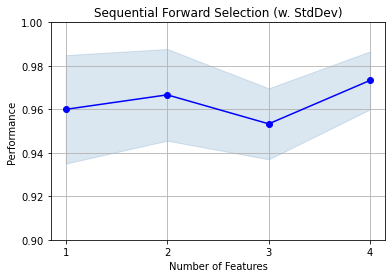

In [36]:
sfs = SFS(knn, k_features=4, forward=True, floating=False, scoring='accuracy', verbose=2,  cv=5)
sfs = sfs.fit(X, y)
sys.stdout.write(BLUE)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.9, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()